In [ ]:
# !pip install bitsandbytes transformers accelerate

In [2]:
from huggingface_hub import login
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import matplotlib.pyplot as plt
import torch
import re
from sklearn.metrics import accuracy_score
import os

In [4]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")

login(token=hf_token)

In [5]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4"
)

In [6]:
model_id = 'google/gemma-2-9b-it'

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quantization_config,
    attn_implementation="eager"
    )

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/857 [00:00<?, ?B/s]

2025-10-05 12:42:45.087226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759668165.294189      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759668165.350013      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors.index.json:   0%|          | 0.00/39.1k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

In [7]:
scitail_test = pd.read_csv('/kaggle/input/scitail-test/scitail_test.csv')

In [8]:
scitail_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   premise                     2126 non-null   object
 1   hypothesis                  2126 non-null   object
 2   label                       2126 non-null   object
 3   hypothesis_graph_structure  2126 non-null   object
dtypes: object(4)
memory usage: 66.6+ KB


In [9]:
scitail_test.head()

,premise,hypothesis,label,hypothesis_graph_structure
0,Based on the list provided of the uses of subs...,"If a substance has a ph value greater than 7,t...",neutral,a substance<>has<>a ph value greater than 7
1,If one or two base pairs are change...,Invertebrates (and higher animals) can also be...,neutral,Invertebrates (and higher animals<>can be plac...
2,"At high temperatures, the solid dye converts i...",Gases and liquids become solids at low tempera...,neutral,Gases and liquids<>become<>solids
3,Chapter 11 Gas and Kinetic Theory .,The behavior of ideal gases is explained by ki...,neutral,The behavior of ideal gases<>is explained<>by ...
4,Both the continental crust and the oceanic cru...,Gabbro is a dark dense rock that can be found ...,neutral,Gabbro<>is<>a dark dense rock that can be foun...


In [ ]:
# Find the max_length for tokenization to avoid wasting computing.
def get_lengths(df: pd.DataFrame) -> tuple:

    prompt_token_lengths = []
    label_token_lengths = []

    for _, row in df.iterrows():
        # Tokenize prompt
        prompt = f"Does the Hypothesis entail the Premise? Answer exactly one word: 'neutral' or 'entailment'. \nPremise: {row['premise']} \nHypothesis: {row['hypothesis']} \nAnswer:"


        prompt_token = tokenizer(prompt)
        prompt_token_lengths.append(len(prompt_token["input_ids"]))


        # Tokenize label
        label_token = tokenizer(row["label"])
        label_token_lengths.append(len(label_token["input_ids"]))
    return prompt_token_lengths, label_token_lengths

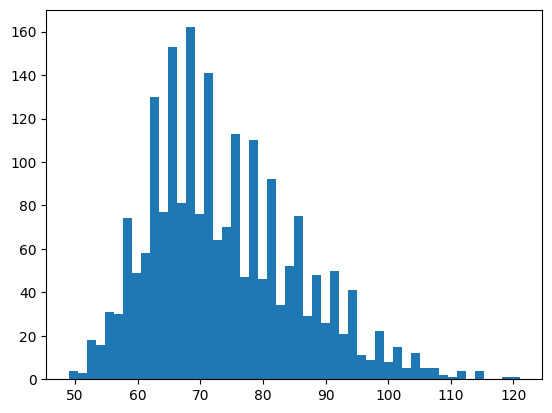

Max prompt length: 121
Max label length: 3


In [11]:
def find_max_length(df: pd.DataFrame) -> None:
    prompt_lengths, label_lengths = get_lengths(df)
    plt.hist(prompt_lengths, bins=50)
    plt.show()

    print("Max prompt length:", max(prompt_lengths))
    print("Max label length:", max(label_lengths))

find_max_length(scitail_test)

In [ ]:
prompt_lengths, _ = get_lengths(scitail_test)
df = pd.DataFrame(prompt_lengths, columns=["length"])
print("Number of examples that have over 128 tokens:",(df["length"] > 128).sum())

Number of examples that have over 256 tokens: 0


In [15]:
class ScitailDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=121):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item = self.dataframe.iloc[idx]
        premise = item['premise']
        hypothesis = item['hypothesis']
        gold_label = item['label']

        # Format the prompt for decoder-only LLM
        prompt = f"Does the Hypothesis entail the Premise? Answer exactly one word: 'neutral' or 'entailment'. \nPremise: {premise} \nHypothesis: {hypothesis} \nAnswer:"

        # Tokenise prompt
        encoding = self.tokenizer(
            prompt,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {"input_ids": encoding["input_ids"].squeeze(),
                "attention_mask": encoding["attention_mask"].squeeze(),
                "labels": gold_label}

In [18]:
# # Test run
# dataset_test = ScitailDataset(scitail_test, tokenizer)
# dataloader = DataLoader(dataset_test, batch_size=4, shuffle=False)

# batch_sample = next(iter(dataloader))
# input_ids = {k: v.to(model.device) for k, v in batch_sample.items() if k != "labels"}

# with torch.no_grad():
#     output = model.generate(**input_ids, max_new_tokens=20)

# out = tokenizer.batch_decode(output, skip_special_tokens=True)

# for text in out:
#     x = re.findall('[e|E]ntailment|[n|N]eutral', text)
#     print(x[2])

neutral
neutral
neutral
entailment


In [16]:
os.getcwd()

'c:\\Users\\User\\Desktop\\DAMA_EAP\\NLI_Study\\Notebooks\\Scitail_Notebooks'

In [19]:
os.path.join(notebook_dir, '..')

'c:\\Users\\User\\Desktop\\DAMA_EAP\\NLI_Study\\Notebooks\\..'

In [15]:
import os
import sys

# Get the directory of the notebook, then go up two levels to the project root
# analysis.ipynb -> notebooks/ -> my_project_repo/
# project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..')) 

# A slightly more robust way:
notebook_dir = os.path.dirname(os.path.abspath(''))
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

if project_root not in sys.path:
    sys.path.append(project_root)

# Now, import using the package name
from utils import utils

In [ ]:
def extract_prediction(outputs_decoded, no_answer):
    predicted_labels = []
    for text in outputs_decoded:
            x = re.findall('[e|E]ntailment|[n|N]eutral', text)
            try:
                predicted_labels.append(x[2].lower()) 
            except IndexError:
                no_answer += 1
                predicted_labels.append("no_answer")
    return predicted_labels

In [ ]:
# Create checkpoint
checkpoint_dir = "/kaggle/working"
os.makedirs(checkpoint_dir, exist_ok=True)
print("Checkpoint directory:", checkpoint_dir)

checkpoint_path = os.path.join(
    checkpoint_dir,
    f"checkpoint_scitail_{model_id.split('/')[1]}.pt"
)

In [ ]:
checkpoint_path

In [ ]:
from tqdm import tqdm

dataset_test = ScitailDataset(scitail_test, tokenizer)
dataloader = DataLoader(dataset_test, batch_size=16, shuffle=False)

# Load checkpoint if it exists
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    predicted_labels = checkpoint["predicted_labels"]
    gold_labels = checkpoint["gold_labels"]
    no_answer = checkpoint["no_answer"]
    start_batch = checkpoint['batch_no']
    print(f"Checkpoint found. Continuing from batch #{start_batch}.")
else:
    gold_labels, predicted_labels = [], []
    start_batch = 0
    no_answer = 0
    print("No checkpoint found.")

with torch.no_grad():
    for i, batch in enumerate(tqdm(dataloader, desc="Evaluating", unit="batch")):
        # Continue from last checkpoint
        if i < start_batch:
            continue

        input_ids_batch = batch["input_ids"].to(model.device) # Move to GPU
        attention_mask_batch = batch["attention_mask"].to(model.device) # Move to GPU
        gold_labels_batch = batch["labels"] # Keep to CPU

        # Get outputs
        outputs = model.generate(input_ids=input_ids_batch, attention_mask=attention_mask_batch, max_new_tokens=6)
        outputs_decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        predicted_labels_batch = extract_prediction(outputs_decoded, gold_labels_batch, no_answer)
        predicted_labels.extend(predicted_labels_batch)
        gold_labels.extend(gold_labels_batch)

        # Save checkpoint
        if i % 50 == 0 or i == len(dataloader) - 1:
            torch.save({"predicted_labels": predicted_labels,
                        "gold_labels": gold_labels,
                        "no_answer": no_answer,
                        "batch_no": i+1}, checkpoint_path)

            print(f"Checkpoint saved: {i+1}, {checkpoint_path}")

In [ ]:
checkpoint = torch.load(checkpoint_path)
predicted_labels = checkpoint["predicted_labels"]
gold_labels = checkpoint["gold_labels"]
no_answer = checkpoint["no_answer"]

In [ ]:
# Calculate accuracy score
accuracy = accuracy_score(gold_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}, no answers: {no_answer}")